In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import seaborn as sns
import io #Used as buffer

# Read Data

In [24]:
path= Path(f'../../data/cluster_results')

In [25]:
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] ##added line for std, remove this will remove std from table
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = float(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
    #df['method'] = f.name.split('_')[0]
    #print(df['method'])
    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [26]:
m = measure_name[index_measure]
files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNdrop' not in f.name)
# files += list(path.glob(f'exp*/*/*nn_p3/*{m}.csv'))
#files += [f for f in path.glob(f'exp*/*/freq*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name] #f'exp*/*/*nn_p3/*{m}.csv'  , 
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
df.rename({'0':m}, axis=1, inplace=True)
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq'],  columns='method') #,'freq' later for adding frequency experiment, ,values=m
data.style.format("{:,.2f}")

In [27]:
df.head()

,mof,std,experiment,function,freq,method
0,23.624263,0.332250,exp1,sphere,4.0,noNNReval_mof.csv
1,0.795509,0.033369,exp1,sphere,4.0,NNnorm_Worst
2,0.787391,0.031064,exp1,sphere,4.0,NNnorm_Random
3,21.422490,0.838330,exp1,sphere,0.5,noNNReval_mof.csv
4,2.036479,0.060792,exp1,sphere,0.5,NNnorm_Worst


In [28]:
def get_table_data(source, index, columns):
    lbl_dict = {'NNnorm_Worst' :'NNW',
                'NNnorm_Random':'NNR',
                'noNNReval'    :'noNN'}
    df = source.copy()
    df.function = df.function.str.title()
    df.method = df.method.apply(lambda x: lbl_dict[x])
    data = pd.pivot_table(df, index=index, columns=columns)
    m = data.columns.levels[0][0]
    # Add std to table
    final_data = data[m].copy()
    for col in data[m].columns:
        final_data[col] = data[m    ][col].apply(lambda x: f'{x:,.2f} (±') +\
                          data['std'][col].apply(lambda x: f'{x:,.2f})'  )
    
    final_data.sort_index(ascending=False, inplace=True)
    data[m].mean(axis=0)
    return final_data

In [29]:
' & '.join([str(o) for o in ss.to_frame().T.round(2).to_numpy().flatten().tolist()])

NameError: name 'ss' is not defined

In [ ]:
table1 = get_table_data(df, index=['experiment','function','freq'], columns=['method']).head()
table1.head()

In [ ]:
table2 = get_table_data(df, index=['function','method'], columns=['experiment','freq'])
table2.head()

# Latex

In [30]:
print(table2.to_csv(float_format='%.2f'))

NameError: name 'table2' is not defined

# Plots chartAll

In [31]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [32]:
# DataFrame we use for plots
d = data.reset_index()
d.columns = ['experiment', 'function', 'freq', 'NNR', 'NNW', 'noNN', 'NNR_std', 'NNW_std', 'noNN_std']
d.head(2)

,experiment,function,freq,NNR,NNW,noNN,NNR_std,NNW_std,noNN_std
0,exp1,rastrigin,0.5,16.039956,16.588359,22.245225,1.095591,0.179049,0.068606
1,exp1,rastrigin,1.0,15.988948,16.486775,22.462684,0.435917,0.152392,0.139244


In [33]:
d1 = d.melt(['experiment','function','freq'], value_vars=['NNR', 'NNW', 'noNN'],
            var_name='method', value_name='mof')
d2 = d.melt(['experiment','function','freq'], value_vars=['NNR_std', 'NNW_std', 'noNN_std'],
            var_name='method', value_name='mof_std')
d2.method = d2.method.str.replace('_std', '')
d = d1.merge(d2)
#d.head()

## Plots 0

In [35]:
test = d.query("experiment=='exp4'").copy()  # & freq==1"
mins = test.groupby('function')['mof'].min()
test['mof_norm'] = test['mof']
for k,v in mins.iteritems():
    test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
#test.head()

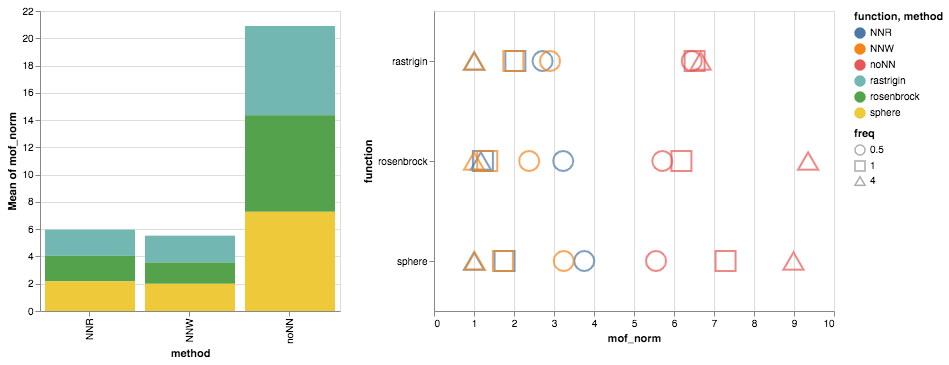

In [36]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['method'])

chart1 = base.mark_bar().encode(
    alt.X('method'),
    alt.Y('mean(mof_norm)'),
    alt.Color('function'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('function'),
    alt.Color('method'),#function
    alt.Shape('freq:N'),
    alt.Tooltip(['mof_norm:Q','mof:Q','freq:Q','function:N'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2

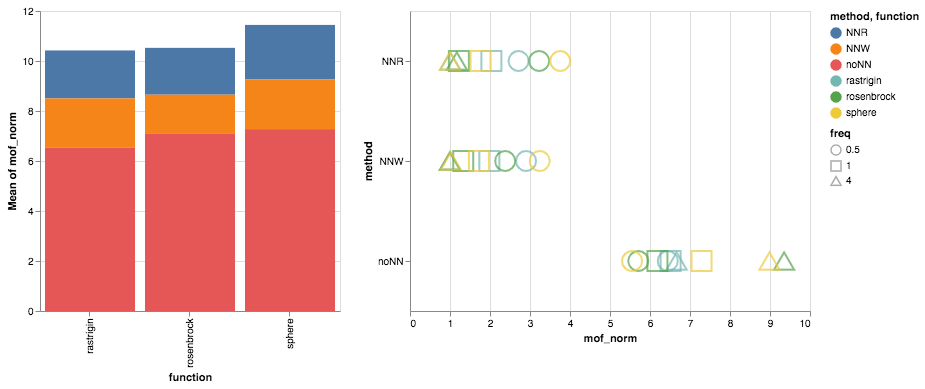

In [37]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['function'])

chart1 = base.mark_bar().encode(
    alt.X('function'),
    alt.Y('mean(mof_norm)'),
    alt.Color('method'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('method'),
    alt.Color('function'),
    alt.Shape('freq:N'),
#     alt.Tooltip(['mof_norm','mof','freq','function'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2.interactive()

## plot 1

In [38]:
def plot_experiment_onlybars(exp):   
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    test['function'] = test['function'].str.title()
    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('method', title='', sort='descending'),
        alt.Y('mean(mof_norm)', title='MOF_norm'),
        alt.Color('function', title=''),
        alt.Tooltip(['mof:Q','mof_norm:Q','function:N']),
#         alt.Column('function', title=''),
    ).properties(
        width=100, height=200, title=exp
    )
    return chart1

chart = (plot_experiment_onlybars('exp1') |
         plot_experiment_onlybars('exp2') |
         plot_experiment_onlybars('exp3') |
         plot_experiment_onlybars('exp4'))
chart.save(str(path/'chartAll.png'), scale_factor=2.0)
chart

SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 77


In [ ]:
def plot_experiment(exp):   
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    
    base = alt.Chart(test)
    selector1 = alt.selection_single(fields=['method'])

    chart1 = base.mark_bar().encode(
        alt.X('method', title=''),
        alt.Y('mean(mof_norm)', title=f'{exp} (mof_norm)'),
        alt.Color('function'),
#         alt.Column('function', title=''),
        opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
    ).properties(
        width=50, height=200
    ).add_selection(selector1)

    chart2 = base.mark_point(size=400).encode(
        alt.X('mof_norm'),
        alt.Y('function', title=''),
        alt.Color('method'),#function
        alt.Shape('freq:N'),
#         alt.Tooltip(['mof_norm','mof','freq','function'])
    ).transform_filter(
        selector1
    ).properties(
        width=200, height=200
    )

    return chart1|chart2
    

In [ ]:
chartworst=(plot_experiment('exp1'))&(plot_experiment('exp3'))
chartworst
# chartworst.save(str(path/'chartworst.png'), scale_factor=2.0)
#|(plot_experiment('exp3'))&(plot_experiment('exp4'))

In [ ]:
chartbest=(plot_experiment('exp2'))&(plot_experiment('exp4'))
chartbest
# chartbest.save(str(path/'chartbest.png'), scale_factor=2.0)

## plot 2

In [ ]:
def plot_exp(exp, axs, colors='method', x_axis='function'):
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v

    for (f,v),ax in zip(test.groupby('freq'),axs):
        sns.barplot(x=x_axis, y='mof_norm', data=v, hue=colors, ax=ax) #y='mof_norm'
        ax.set_title(f'freq={f}')
        ax.get_legend().remove()
    ax.legend(loc='best', bbox_to_anchor=(1.05, 0.52, 0.5, 0.5))
    for ax in axs[1:]: ax.set_ylabel('')
    for ax in axs: ax.set_xlabel('')

def plot_all_exp(colors='method', x_axis='function'):
    fig,axss = plt.subplots(4, 3, sharey=False, figsize=(10,12))
    for exp,axs in zip(['exp1','exp2','exp3','exp4'],axss): plot_exp(exp, axs, colors, x_axis)
    for axs in axss[1:]:
        for ax in axs: ax.set_title('')
    plt.tight_layout()

In [ ]:
#method versus functions
freqMethod = plot_all_exp(colors='method', x_axis='function')
freqMethod

In [ ]:
#freqMethod.save(str(path/'freqMethod.png'), scale_factor=2.0)

In [ ]:
#functions versus methods
plot_all_exp(colors='function', x_axis='method')

# Arr plot

## Read Data

In [39]:
path= Path(f'../../data/cluster_results')

In [40]:
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] ##added line for std, remove this will remove std from table
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = float(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
    #df['method'] = f.name.split('_')[0]
    #print(df['method'])
    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=2

In [41]:
m = measure_name[index_measure]
files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNnorm' in f.name)
# files += list(path.glob(f'exp*/*/*nn_p3/*{m}.csv'))
files += [f for f in path.glob(f'exp*/*/freq*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name] #f'exp*/*/*nn_p3/*{m}.csv'  , 
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
df.rename({'0':m}, axis=1, inplace=True)
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq'],  columns='method') #,'freq' later for adding frequency experiment, ,values=m
data.style.format("{:,.2f}")

In [42]:
#to add std to table
final_data = data[m].copy()

for col in data[m].columns:
    final_data[col] = data[m][col].apply(lambda x: f'{x:,.2f} (±') + data['std'][col].apply(lambda x: f'{x:,.2f})')
final_data

method                     NNnorm_Random   NNnorm_Worst noNNReval_arr.csv
experiment function   freq                                               
exp1       rastrigin  0.5   0.03 (±0.00)   0.04 (±0.00)      0.01 (±0.00)
                      1.0   0.08 (±0.05)   0.09 (±0.09)      0.01 (±0.00)
                      4.0   0.17 (±0.09)   0.20 (±0.10)      0.03 (±0.00)
           rosenbrock 0.5   0.18 (±0.02)   0.21 (±0.01)      0.02 (±0.01)
                      1.0   0.31 (±0.12)   0.27 (±0.02)      0.02 (±0.00)
                      4.0   0.42 (±0.10)   0.37 (±0.03)      0.02 (±0.00)
           sphere     0.5   0.28 (±0.02)   0.35 (±0.01)      0.02 (±0.01)
                      1.0   0.50 (±0.02)   0.49 (±0.01)      0.01 (±0.00)
                      4.0   0.65 (±0.02)   0.63 (±0.02)      0.03 (±0.00)
exp2       rastrigin  0.5   0.05 (±0.02)   0.09 (±0.10)      0.18 (±0.16)
                      1.0   1.39 (±5.19)   1.96 (±8.67)      0.13 (±0.07)
                      4.0   0.46 (±0.94)  2.71 (±13.90)      0.13 (±0.05)
           rosenbrock 0.5   0.26 (±0.02)   0.28 (±0.01)      0.26 (±0.04)
                      1.0   0.33 (±0.03)   0.34 (±0.02)      0.31 (±0.05)
                      4.0   0.50 (±0.05)   0.47 (±0.03)      0.38 (±0.01)
           sphere     0.5   0.31 (±0.02)   0.45 (±0.03)      0.44 (±0.09)
                      1.0   0.63 (±0.03)   0.65 (±0.02)      0.48 (±0.09)
                      4.0   0.84 (±0.05)   0.84 (±0.02)      0.53 (±0.20)
exp3       rastrigin  0.5   0.02 (±0.00)   0.02 (±0.00)      0.03 (±0.00)
                      1.0   0.02 (±0.00)   0.02 (±0.00)      0.02 (±0.00)
                      4.0   0.08 (±0.10)   1.00 (±4.65)      0.15 (±0.14)
           rosenbrock 0.5   0.35 (±0.02)   0.38 (±0.01)      0.41 (±0.04)
                      1.0   0.49 (±0.03)   0.50 (±0.03)      0.51 (±0.52)
                      4.0   1.03 (±0.10)   0.99 (±0.06)      1.65 (±0.55)
           sphere     0.5   0.61 (±0.01)   0.61 (±0.01)        nan (±nan)
                      1.0   0.75 (±0.03)   0.75 (±0.03)        nan (±nan)
                      4.0   1.51 (±1.44)   1.06 (±0.80)        nan (±nan)
exp4       rastrigin  0.5   0.29 (±0.01)   0.26 (±0.01)      0.05 (±0.03)
                      1.0   0.42 (±0.02)   0.42 (±0.02)      0.09 (±0.15)
                      4.0   0.65 (±0.02)   0.67 (±0.02)      0.11 (±0.08)
           rosenbrock 0.5   0.42 (±0.08)   0.44 (±0.02)      0.50 (±0.22)
                      1.0   0.58 (±0.04)   0.60 (±0.10)      0.36 (±0.10)
                      4.0   0.82 (±0.02)   0.90 (±0.54)      0.40 (±0.59)
           sphere     0.5   0.51 (±0.77)   0.38 (±0.02)      0.39 (±0.04)
                      1.0   0.55 (±0.07)   0.56 (±0.06)      0.26 (±0.04)
                      4.0   0.84 (±0.02)   0.82 (±0.01)      0.12 (±0.11)

## show plots

In [43]:
plot_df = data['arr'].reset_index()
plot_df.rename({'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNNReval_sr.csv':'noNN'}, axis=1, inplace=True)
#plot_df.head()

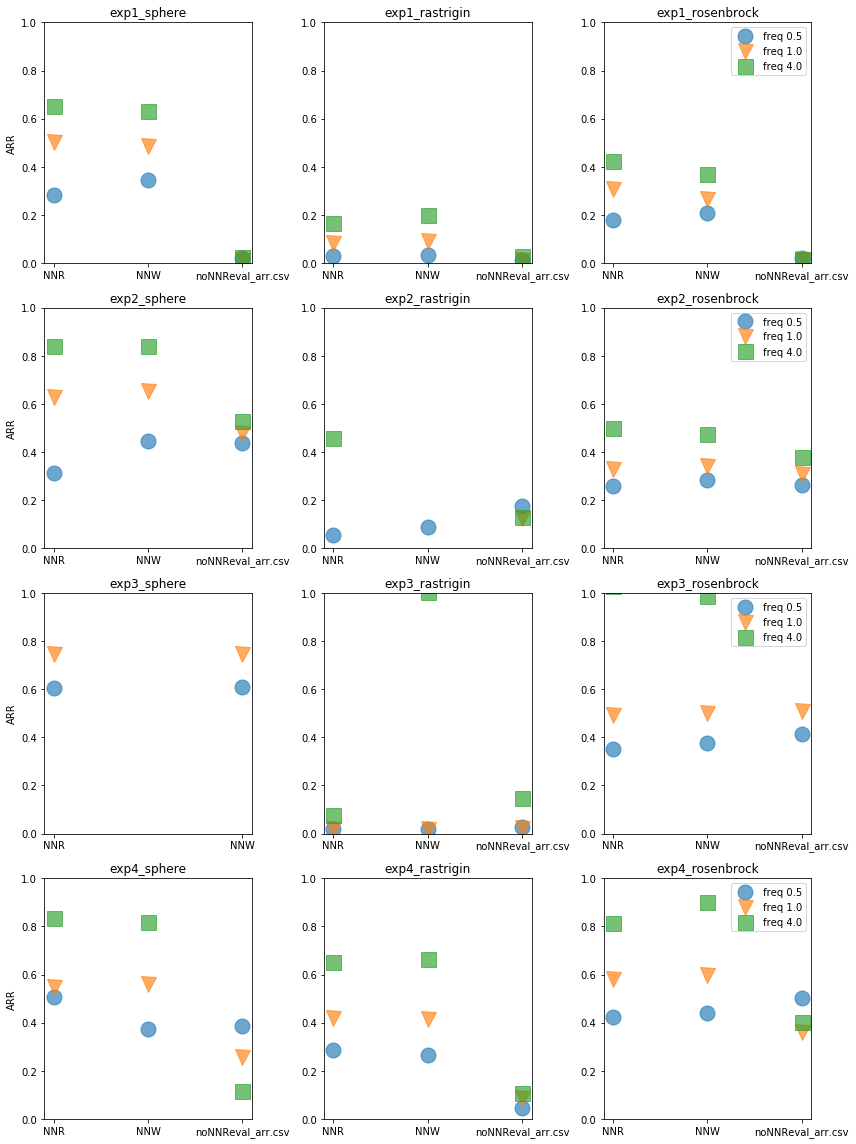

In [44]:
fig,axss = plt.subplots(4, 3, figsize=(12,16))
experiments = ['exp1','exp2','exp3','exp4']
functions = ['sphere','rastrigin','rosenbrock']
freqs = [0.5, 1.0, 4.0]
for exp,axs in zip(experiments,axss):
    axs[0].set_ylabel('ARR')#exp
    for func,ax in zip(functions,axs):
        t = (plot_df[(plot_df.function==func)&(plot_df.experiment==exp)]
                    .drop(['experiment','function'], axis=1)
                    .set_index('freq'))
        for freq,symbol in zip(freqs,['o','v','s']):
            ax.plot(t.loc[freq], symbol, markersize=15, alpha=0.65, label=f'freq {freq:0.1f}')
            
        ax.set_title(f'{exp}_{func}')
        ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout()

### average based on functions

In [45]:
fig,axs = plt.subplots(1, 4, figsize=(14,4))
experiments = ['exp1','exp2','exp3','exp4']
functions = ['sphere','rastrigin','rosenbrock']
freqs = [0.5, 1.0, 4.0]
for exp,ax in zip(experiments,axs):
#     axs[0].set_ylabel(exp)
    t = (plot_df[plot_df.experiment==exp]
                .drop(['experiment'], axis=1)
                .groupby('freq').mean())
    for freq,symbol in zip(freqs,['o','v','s']):
        ax.plot(t.loc[freq], symbol, markersize=15, alpha=0.65, label=f'freq {freq:0.1f}')

    ax.set_title(f'{`zexp}')
    ax.set_ylim(0,1)
axs[-1].legend()
plt.tight_layout()

SyntaxError: invalid syntax (<fstring>, line 1)

In [ ]:
t = (plot_df[plot_df.experiment=='exp3']
                .drop(['experiment'], axis=1)
#                 .groupby('freq')
    )

In [ ]:
t

# Final Plot

## functions

In [68]:
col_by_freq = True
col_palette = 'Set3'

def get_files(m):
    files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNdrop' not in f.name)
    #files  = list(f for f in path.glob(f'exp*/*/freq1nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'Cw' in f.parent.name)
    files += [f for f in path.glob(f'exp*/*/freq1*nn_p3nn_s1nn_tw1*bs4*/*{m}.csv') if 'Cw' in f.parent.name]
    #print(files)
    return files

def read_csv(f,m):
    df = pd.read_csv(f)
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    df['freq'] = float(name[4:].split('n')[0])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
#     df['method'] = f.name.split('_')[0]
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def get_data(m, normalize=False):
    short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNNReval_sr.csv':'noNN',
                  'noNNReval_arr.csv':'noNN', 'noNNReval_mof.csv':'noNN'}
    files = get_files(m)
    data = pd.concat([read_csv(f,m) for f in files])
    data.method = data.method.apply(lambda x: short_dict[x])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data

def plot_one(data, m, normalize=False, title='', title_size=14, col_by_freq=col_by_freq, col_palette=col_palette,
             legend=False, hide_x=True, hide_y=True, ax=None, do_lim=True, ll=0.2, ul=0.8):
    m = m.upper()
    if normalize: m = m + '_norm' 
    if ax is None: fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.boxplot('method' if col_by_freq else 'freq', m, hue='freq' if col_by_freq else 'method',
                data=data, palette=col_palette,
                # width=2.5,
                linewidth=0.5, fliersize=0, ax=ax)
    if not legend: ax.get_legend().remove()
    if do_lim:
        ax.set_ylim(-0.05,1.05)
    else:
        g = data.groupby(['method','freq'])[m]
        q1,q3 = g.quantile(ll),g.quantile(ul)
        iqr = q3-q1
        lower_lim = (q1 - 1.5*iqr).min()
        upper_lim = (q3 + 1.5*iqr).max()
        lower_lim = data[m][data[m]>=lower_lim].min()
        upper_lim = data[m][data[m]<=upper_lim].max()
        ax.set_ylim(lower_lim,upper_lim)
        
    ax.set_xlabel('')
    if hide_x: ax.set_xticklabels([])
    if hide_y: ax.set_ylabel('')
    ax.set_title(title, size=title_size)
    return ax

def plot_all_vertical(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                      ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(4, 3, figsize=(20,16), sharex=False, sharey=False)
    for i,(axs,exp) in enumerate(zip(axss,['exp1','exp2','exp3','exp4'])):
        first_exp = i==0
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = j==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        ax.legend(loc='upper left', ncol=3)
    plt.tight_layout()
    return fig,axss

def plot_all_horizontal(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                        ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(3, 4, figsize=(20,12), sharex=False, sharey=False)
    for i,exp in enumerate(['exp1','exp2','exp3','exp4']):
        first_exp = i==0
        axs = axss[:,i]
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = i==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        
    for axs in axss: axs[-1].legend(loc='upper right', ncol=3)
    plt.tight_layout()
    return fig,axss

## Plots

In [69]:
path= Path(f'../../data/cluster_results')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


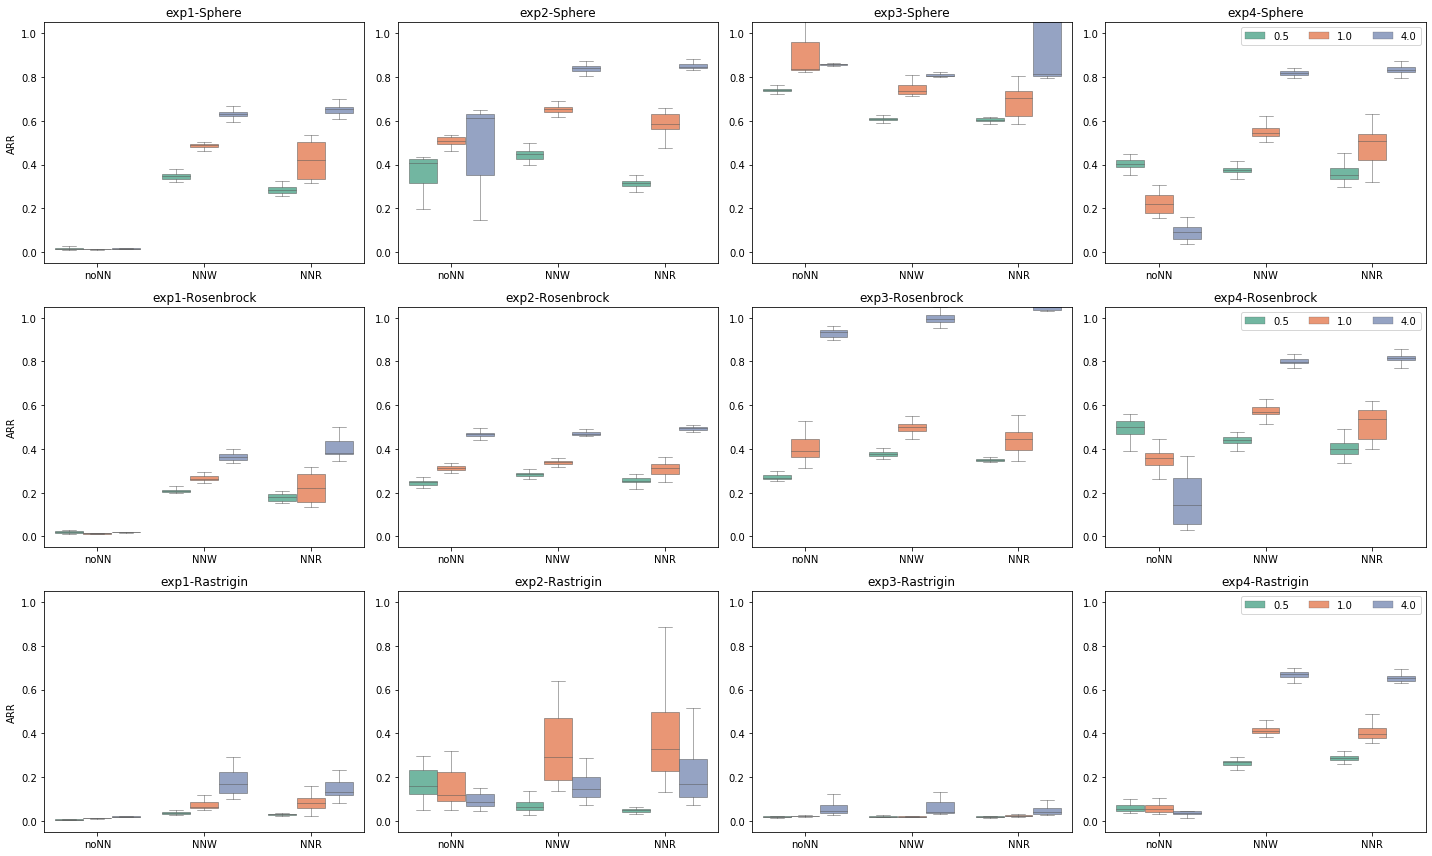

In [70]:
fig,axs = plot_all_horizontal('arr', title_size=12, col_by_freq=True, col_palette='Set2')
fig.savefig(path/'ARR.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


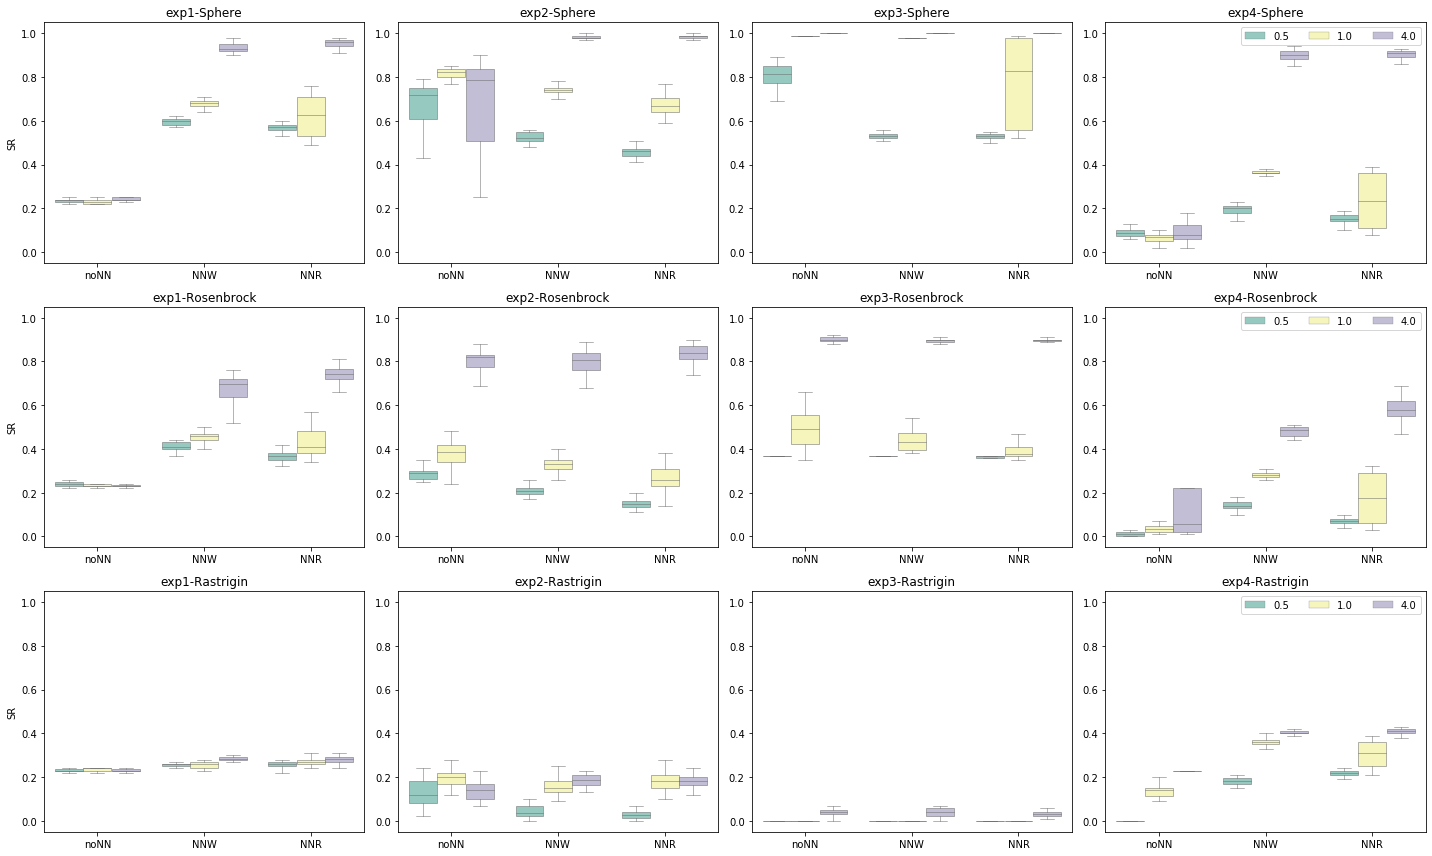

In [71]:
fig,axs = plot_all_horizontal('sr', title_size=12, col_by_freq=True)#, col_palette='Set3'
fig.savefig(path/'SR.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


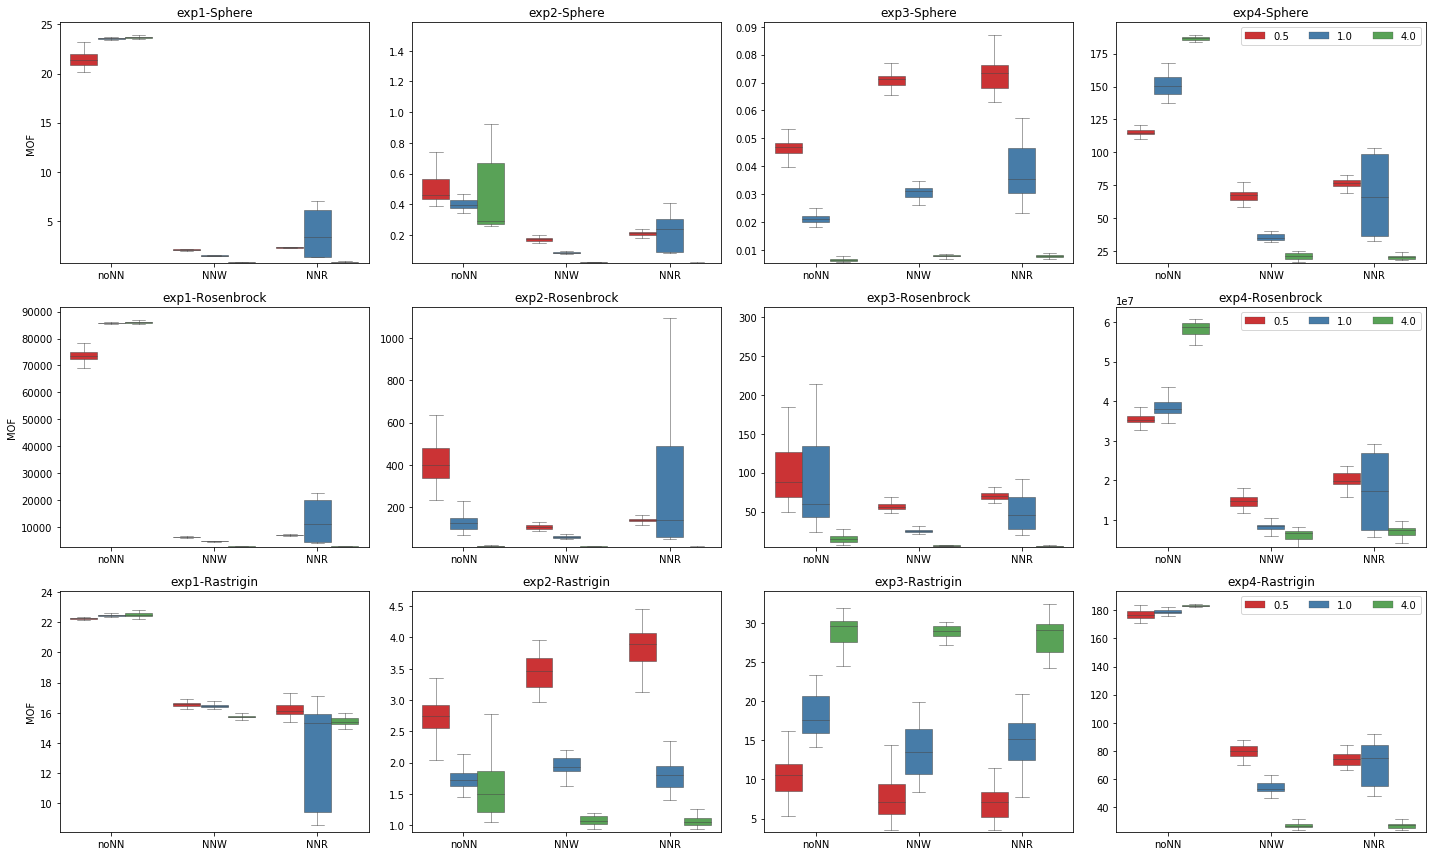

In [72]:
fig,axs = plot_all_horizontal('mof', title_size=12, col_by_freq=True, col_palette='Set1', do_lim=False, ll=0.2, ul=0.8)
for ax in axs.flatten():
    ll,ul = ax.get_ylim()
    ax.set_ylim(ll*0.95, ul*1.05)
    
fig.savefig(path/'MOF.eps', dpi=400, format='eps')

In [73]:
# This if for normalize MOF values
fig,axs = plot_all('mof', normalize=True, title_size=12, col_by_freq=True, col_palette='Set1', do_lim=False,
                   ll=0.2, ul=0.8)
for ax in axs.flatten():
    ll,ul = ax.get_ylim()
    ax.set_ylim(ll*0.95, ul*1.05)
    
fig.savefig(path/'MOFnorm.eps', dpi=400, format='eps')

NameError: name 'plot_all' is not defined

In [ ]:
get_data('mof').query("experiment == 'exp3' and freq==1").groupby(['function','freq','method']).mean()

In [ ]:
get_data('arr').query("experiment == 'exp3'").groupby(['function','freq','method']).mean()

# ----